## #TODO:
* Plans for tonight's computation
* All chromosomes, dump in pkl
* Concat pandas dfs

positioning.sample1m.txt.gz

The file positioning.sample1m.txt.gz contains nucleosome positioning 
scores calculated for a random sample of 1 million 200bp regions that
contain at least 50 midpoints.

These were used to generate figure 2A in our paper.

The columns are as follows:

CHR - chromosome
START - start of 200bp window (inclusive numbering with first chromosome base numbered 1)
END - end of 200bp window
PEAK - max score position in window
PEAK.NODUP - peak score position after filtering duplicate read pairs
PEAK.SIM - peak score position from simulated read pairs
PEAK.SE - peak score position using only single-end read data
N.MIDS - number of midpoints in window
N.NODUP.MIDS - number of non-duplicate midpoints in window 
N.SIM.MIDS - number of simulated midpoints in window
N.SE.MIDS - number of single-end midpoints in window
SCORE - max score of window
NODUP.SCORE - max non-duplicate score of window
SIM.SCORE - max simulated score of window
SE.SCORE - max single-end score of window
STRINGENCY - Valouev et al. 2011 stringency of window
SIM.STRINGENCY - Valouev et al. 2011 stringency for simulated read pairs


-----------------------------------------------

peaks.min_peak_score_0.6.thresh_0.5.txt


The file peaks.min_peak_score_0.6.thresh_0.5.txt contains the locations
of well-positioned nucleosomes. This file contains 
regions that exceed a score threshold of 0.5, and that 
contain a 'peak' region of at least 0.6. The file contains
the following columns:

Chromosome
Start position of region with score > 0.5 (inclusive, first base is 1)
End position of region with score > 0.5
Peak position (position with max positioning score, position closest to
               midpoint of region breaks ties)
Score at peak position




In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm

# Preparing data from web

with open('peaks.min_peak_score_0.6.thresh_0.5.txt' , 'r') as f:
#     next(f)
    peaks = f.read()
# [4:] is because of the annotation lines
df_peaks = pd.DataFrame([sub.split("\t") for sub in peaks.split('\n')][4:], columns=['chrom', 'start', 'end', 'peak_pos', 'score'])
df_peaks.drop(df_peaks.tail(1).index, inplace=True)
df_peaks.head()

# https://pypi.python.org/pypi/pyliftover
from pyliftover import LiftOver
lo = LiftOver('hg18', 'hg19')
lo.convert_coordinate('chr1', 1000000)  # testing 

row_to_delete = []
def liftover(row):
    value = lo.convert_coordinate(row['chrom'], int(row['start']))
    if value == []:
        row_to_delete.append(row)
    else:
        row['start'] = int(value[0][1])
    
    value = lo.convert_coordinate(row['chrom'], int(row['end']))
    if value == []:
        row_to_delete.append(row)
    else:
        row['end'] = int(value[0][1])
    
    value = lo.convert_coordinate(row['chrom'], int(row['peak_pos']))
    if value == []:
        row_to_delete.append(row)
    else:
        row['peak_pos'] = int(value[0][1])
    
    return row

uplifted = df_peaks.apply(liftover, axis=1)
#df_peaks.iloc[0,0]

# Deleting rows that can't be uplifted
ind_row_to_delete = [x.name for x in row_to_delete]
ind_row_to_delete = list(set(ind_row_to_delete))
len(ind_row_to_delete)
uplifted.drop(ind_row_to_delete, inplace=True)
# uplifted.to_csv('peaks.min_peak_score_0.6.thresh_0.5.csv')
uplifted.head()

In [79]:

base_path = "/home/shared/STEMLOOPS/hg19/S15-30_L0-10_M5"
filename = "chr1.fna.S15-30_L0-10_M5.pal"
path_to_file = os.path.join(base_path, filename)
with open(path_to_file , 'r') as f:
#     next(f)  # if there is description line
    splitted = f.read().split('\n')  # raw file separated by \n's

from tqdm import tqdm_notebook as tqdm
cols = ['start', 'end', 'len_stem', 'len_loop']#, 'seq_left', 'seq_right', 'full_seq', '1', '2', '3']
df = pd.DataFrame([sub.split("\t")[:4] for sub in tqdm(splitted[:1000000])], columns=cols)  # TODO: full file (30 times bigger)
df = df.apply(pd.to_numeric)
df.head()

HBox(children=(IntProgress(value=0, max=1000000), HTML(value='')))

,start,end,len_stem,len_loop
0,10476,10510,16,6
1,10476,10511,16,7
2,10476,10511,16,6
3,10500,10533,16,4
4,10500,10533,16,3


In [ ]:
cumsum_arr = np.zeros((1000))

for peak_pos in tqdm(pd.to_numeric(uplifted.peak_pos)):
    temp_df = df[(df['start']> peak_pos-500) & (df['end']< peak_pos+500)]
    for ind, row in temp_df.iterrows():
        for i in range(int(row['start']) - peak_pos + 500, int(row['end']) - peak_pos + 500):
            cumsum_arr[i] +=1
# cumsum_arr

x = np.arange(-500, 500)
plt.plot(x, cumsum_arr)
plt.ylabel('Number of sec. structures')
plt.xlabel('Centered position')
plt.savefig('Chr1_S15-30_centered_plot.png')

### Because S15-30 gave irrelevant result, we'll test S16-30

In [82]:
base_path = "/home/shared/STEMLOOPS/hg19/S16-50_L0-10_M3"
filename = "chr1.fa.S16-50_L0-10_M3.pal.cleaned"
path_to_file = os.path.join(base_path, filename)
with open(path_to_file , 'r') as f:
#     next(f)  # if there is description line
    splitted = f.read().split('\n')  # raw file separated by \n's

cols = ['start', 'end', 'len_stem', 'len_loop']#, 'seq_left', 'seq_right', 'full_seq', '1', '2', '3']
df = pd.DataFrame([sub.split("\t")[:4] for sub in tqdm(splitted)], columns=cols)  # TODO: full file (30 times bigger)
df = df.apply(pd.to_numeric)
df.head()

HBox(children=(IntProgress(value=0, max=100048), HTML(value='')))

,start,end,len_stem,len_loop
0,10631.0,10680.0,21.0,10.0
1,10660.0,10709.0,21.0,10.0
2,10689.0,10738.0,21.0,10.0
3,10718.0,10767.0,21.0,10.0
4,10747.0,10796.0,21.0,10.0


HBox(children=(IntProgress(value=0, max=1037767), HTML(value='')))

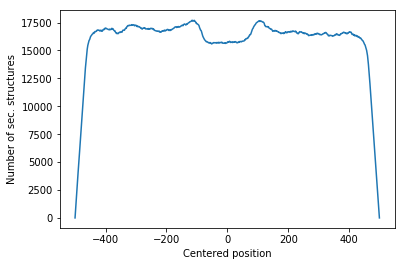

In [84]:
cumsum_arr = np.zeros((1000))

for peak_pos in tqdm(pd.to_numeric(uplifted.peak_pos)):
    temp_df = df[(df['start']> peak_pos-500) & (df['end']< peak_pos+500)]
    for ind, row in temp_df.iterrows():
        for i in range(int(row['start']) - peak_pos + 500, int(row['end']) - peak_pos + 500):
            cumsum_arr[i] +=1
# cumsum_arr

x = np.arange(-500, 500)
plt.plot(x, cumsum_arr)
plt.ylabel('Number of sec. structures')
plt.xlabel('Centered position')
plt.savefig('Chr1_S16-50_centered_plot.png')

### It's better. Let's check quadruplexes:

In [99]:
base_path = "/home/konovalovdmitry/results"
filename = "chr1.out"
path_to_file = os.path.join(base_path, filename)
df = pd.read_csv(path_to_file, sep=' ', header=None)#, usecols=['chr', 'start', 'end', 'seq'])
cols = ['chr', 'start', 'end', 'seq']
df.columns = cols
df.drop(['seq', 'chr'], axis=1, inplace=True)
df = df.apply(pd.to_numeric)
df.tail()

,start,end
34898,249123916,249123941
34899,249155610,249155635
34900,249197010,249197036
34901,249239808,249239833
34902,249240358,249240380


HBox(children=(IntProgress(value=0, max=1037767), HTML(value='')))

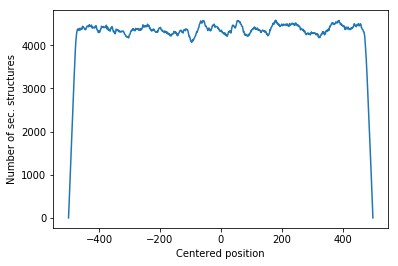

In [100]:
cumsum_arr = np.zeros((1000))

for peak_pos in tqdm(pd.to_numeric(uplifted.peak_pos)):
    temp_df = df[(df['start']> peak_pos-500) & (df['end']< peak_pos+500)]
    for ind, row in temp_df.iterrows():
        for i in range(int(row['start']) - peak_pos + 500, int(row['end']) - peak_pos + 500):
            cumsum_arr[i] +=1
# cumsum_arr

x = np.arange(-500, 500)
plt.plot(x, cumsum_arr)
plt.ylabel('Number of sec. structures')
plt.xlabel('Centered position')
plt.savefig('Chr1_quadruplexes_centered_plot.png')

### Hmm